# Visual Inspection of Motorcycle Connecting Rods

### Abstract
Blob analysis is the set of processes that aims to extract specific features from scene objects, usually referred to as *blobs*. 
\
This project aims the extraction of many features from a set of connecting rods images. In particular, for each blob the following features are required:

* <a href=#Classification>Classification/type of the rod (there are only 2 types)</a>
* <a href=#Orientation>Position and Orientation (modulo $\pi$)</a>
* <a href=#Length-and-Width>Length ($L$), Width ($W$).</a>
* <a href=#Width-at-Barycentre> Width at the barycenter ($W_B$)</a>
* <a href=#Centre-Position-and-Radius>For each hole, position of the centre and diameter size.</a>

Also, many changes may affect the images:
* Images may contain other objects (i.e. screws and washers) that need not to be analysed by the system (such objects are often referred to as “distractors”)
* Rods can have contact points but do not overlap one to another.  
* The inspection area may be dirty due to the presence of scattered <a href=#Iron-powder>iron powder</a>.

### This work has been done as a project for the *Computer Vision and Image Processing* course, University of Bologna (UNIBO)

## Blob Analysis workflow
1) Read image.
2) Crop ROI (regions of interests: obtain the portions of image containing the objects we want to inspect. 
3) Binarization: isolate *FOREGROUND* and *BACKGROUND* pixels. 
4) Connected component labeling: separate and enumerate the objects to be analysed.
5) Feature extraction

In [90]:
img_path = 'img/TESI51.BMP'

In [91]:
# retrieve local name of the image (i.e. without path)
img_name = img_path.split('/')[-1]

# remove file extension
src_name = "".join(img_name.split('.')[:-1])

OUT_DIR = 'out/'

# 1. Read Image

Not much to say about it, isn't it?

In [92]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# uncomment below lines to test the program on custom scales
# SIZE_FACTOR = 4  # MUST BE INT
#new_size = np.array(gray.shape)[::-1]*SIZE_FACTOR
#gray = cv2.resize(gray, new_size)
src = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

# 2. Crop ROI

Not needed, those images are already a ROI :)

# 3. Binarization
Binarization according to Otsu's threshold. Otsu's algorithm returns the optimal threshold that maximizes the *inter-class variance*, an indicator that tells how well two classes (FOREGROUND and BACKGROUND) are separated by thresholding with a specific value.
\
For further details, take a look at https://en.wikipedia.org/wiki/Otsu%27s_method

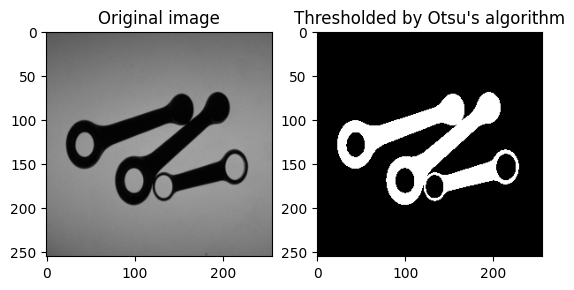

In [93]:
# Otsu's threshold is computed by OpenCV by passing the cv2.THRESH_OTSU flag
th, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
binary_image = np.asarray(binary_image/255, 'uint8') # normalize

plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(src, cmap='gray')

plt.subplot(1,2,2)
plt.title("Thresholded by Otsu's algorithm")
plt.imshow(binary_image, cmap='gray')
plt.show()

# Iron powder

The powder acts as salt-and-pepper noise, which can be dealt with using a *median filter*. High-density areas are filtered out by performing many iterations.
Median filter takes a set of pixel intensities as input and return the *median* value of the SORTED input.
\
\
So, assuming we have $x = [20, 8, 253, 90]$ as input and a sliding window of size $k = 3$, we will have
\
$y = median\_filter(x)$, where \
$y[1] = median[sort(20,20,8)] = median[8,20,20] = 20
\\
y[2] = median[sort(20,8,253)] = median[8,20,253] = 20
\\
y[3] = median[sort(8, 253, 90)] = median[8,90,253] = 90
\\
y[4] = median[sort(253, 90, 90)] = median[90,90,253] = 90$
\
So, accordin to that: $median\_filter(sort([20, 8, 253, 90]))$ (having kernel-size = 3) $= [20, 20, 90, 90]$

In [94]:
from scipy.ndimage import median_filter
signal = np.array([[20, 8, 253, 90]])
print(f"median(sort({signal}))\t =\t {median_filter(signal, size=3)}")

median(sort([[ 20   8 253  90]]))	 =	 [[20 20 90 90]]


A median filter is applied to an image by applying the ($k$ x $k$) sliding window on each pixel.

Median filtering actually denoises without introducing significant blur. High-density areas are filtered out by performing many iterations.

After several experiments i've seen that using a 3x3 kernel yields to a good filtering, since bigger kernels would delete some pixels among the border of the holes, if not wide enough.

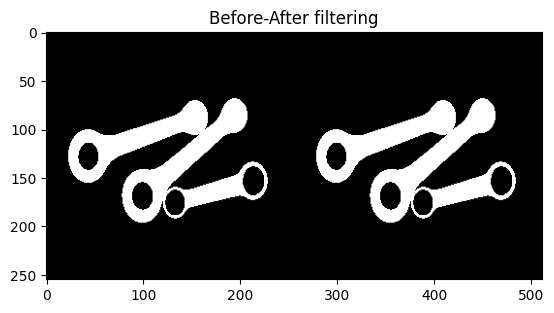

In [95]:
def remove_powder(src, ksize=3, max_iter=5):
    iterations = 0
    median = src.copy()
    last_iteration = np.zeros(median.shape)

    # filtering stops as soon as the last 
    # two filtered images are equal
    while not np.array_equal(median,last_iteration) and iterations < max_iter:
        iterations += 1
        last_iteration = median.copy()
        median = median_filter(median, ksize)     # median filtering
        # logical-AND between the filtered and the source binary image to
        # prevent from the median filter to fill regions aroung points 
        # featuring high convexity defection
        median = src & median
    return median

median = remove_powder(binary_image, 3)

plt.title(f'Before-After filtering')
plt.imshow(np.hstack((binary_image, median)), cmap='gray')
plt.show()

# 4. Connected component labeling

Labeling consists on scanning the input binary image and check for the intensity of any foreground pixel's neighbourhood, according to either 4-connectivity or 8-connectivity.

In [96]:
BACKGROUND = 0 # White
FOREGROUND = 1 # Black

In [97]:
def crop_object(img, label=FOREGROUND):
    # coords
    y, x = np.where(img == label)[:2] if label is not -1 else np.nonzero(img)[:2]
    
    # max and min coordinates
    x_min, y_min = np.min(x), np.min(y)
    x_max, y_max = np.max(x), np.max(y)
    
    # crop
    out = img[y_min:y_max+1, x_min:x_max+1].copy()

    return out

In [98]:
def label_components(img):
    # lookup table has dynamic size and
    # will grow as new labels are found
    lookup_table = [0]

    # pad to prevent bad indexing errors
    pad = 5
    labeled_image = np.pad(img, pad)

    # new_label counter
    current_label = 0
    
    H, W = labeled_image.shape
    for i in range(H):
        for j in range(W):
            lx = BACKGROUND
            # check if foreground
            if labeled_image[i, j] == FOREGROUND:
                # take labels of the upper and left-sided px of [i, j]
                lp = labeled_image[i-1, j]
                lq = labeled_image[i, j-1]
                if lp == BACKGROUND and lq == BACKGROUND:
                    # new connected component found
                    current_label += 1
                    lx = current_label
                    lookup_table.append(current_label)
                elif lp != lq and lp != BACKGROUND and lq != BACKGROUND:
                    # both left and upper pixels are foreground, but
                    # with different labels.
                    # equivalence between lp and lq has to be handled
                    lx = lq
                    lp_label = lookup_table[lp]
                    # handling equivalence
                    for k in range(len(lookup_table)):
                        if lookup_table[k] == lp_label:    lookup_table[k] = lookup_table[lq]

                elif lq != BACKGROUND:    lx = lq
                elif lp != BACKGROUND:    lx = lp
                    
            labeled_image[i, j] = lx  
    
    # mapping labels
    labeled_image = labeled_image[pad:-pad, pad:-pad]
    labeled_image = np.reshape([lookup_table[k] for k in labeled_image.flatten()], img.shape)
    unique_labels = np.unique(labeled_image)
    unique_labels = unique_labels[unique_labels != BACKGROUND]  # cutting off the background label
    return labeled_image, unique_labels

In [99]:
labeled_components, labels = label_components(median)

Since labels(e.g. Intensities of each blob) could have low contrast, intensities are reverted and gray-scale labels are turned into RGB ones, just to enhance different blobs (different blobs have different labels/intensities), this won't affect feature detections.

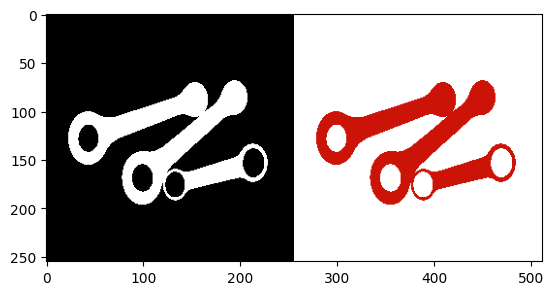

In [100]:
import random as rng

def enhance_contrast(labeled_components, labels, revert=True):

    src = labeled_components.copy()
    src = np.stack((src,)*3, axis=-1)    # gray-scale to RGB

    # assign a random RGB label to a grey-scaled one
    for l in labels:
        rgb_label = [rng.randint(0,256), rng.randint(0,256),rng.randint(0,256)]
        src = np.where(src == l, rgb_label, src)

    if revert:  src = [255, 255, 255] - src

    return src

after_enhance = enhance_contrast(labeled_components, labels)
before_enhance = np.stack((median*255,)*3, axis=-1)

res = np.hstack((before_enhance, after_enhance))    # stack images side-by-side
plt.imshow(res)
plt.show()

### Blob separation

just cropping the original image into several windows, one for each blob.

In [101]:
def show_blob(src, crop=True):
    img = crop_object(src) if crop else src.copy()
    plt.imshow(img, cmap='gray')
    plt.show()


def show_many_blobs(lst, crop=True, inline=True):
    if inline:  
        for i, blob in enumerate(lst):
            img = crop_object(blob) if crop else blob
            plt.subplot(1, len(lst), i+1)
            plt.title("Blob "+str(i+1))
            plt.imshow(img, cmap='gray')
        
        plt.show()
    else:   [show_blob(b, crop) for b in lst]


def separate_blob(img, label=FOREGROUND, crop=True):
    if crop:    out = crop_object(img, label)
    else:       out = img.copy()
    
    # any px that does not belong to the blob is set to zero
    out[out != label] = 0  # if we don't do so, a portion of another blob may occur inside the crop
    
    return (out/label).astype('uint8')

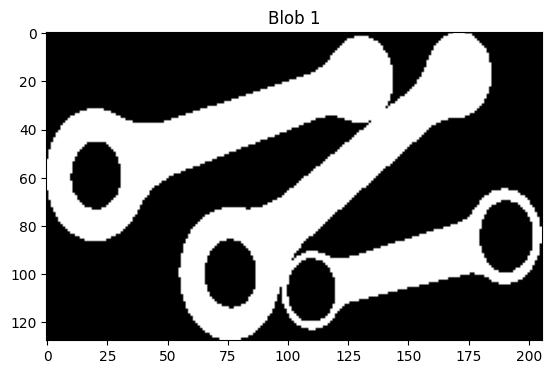

In [102]:
blobs = [separate_blob(labeled_components, l, crop=False) for l in labels]
show_many_blobs(blobs, crop=True)

# 5. Feature Extraction

Before extracting any feature, we need to:
* <a href=#Screw-detection>Remove screws</a>
* <a href=#Remove-washers>Remove washers</a>
* <a href=#Remove-Contact-Points>Remove contact points</a>

### Obtain contours
Contours will be used as a basis to extract any feature from the images, since they encodes every relevant information about them.

findContours() -> 	contours, hierarchy. See https://docs.opencv.org/4.5.3/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0

For each i-th contour "contours[i]", the elements hierarchy[i][0] , hierarchy[i][1] , hierarchy[i][2] , and hierarchy[i][3] are set to 0-based indices in contours of the next and previous contours at the same hierarchical level, the first child contour and the parent contour, respectively. If for the contour i there are no next, previous, parent, or nested contours, the corresponding elements of hierarchy[i] will be negative. 

In [103]:
def get_contours(blobs):
    # findContours returns (nested_contours, hierarchy)
    contour_list = [cv2.findContours(blob, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE) for blob in blobs]
    cnts = [c[0] for c in contour_list]

    # i-th contour is external if the 4-th column of hierarchies is "-1"
    ext_cnts = [cnt[0] for cnt in cnts]

    # i-th contour is an hole if the 3-th column of hierarchies is "-1"
    hole_cnts = [cnt[1:] for cnt in cnts]

    return ext_cnts, hole_cnts

ext_cnts, hole_cnts = get_contours(blobs)

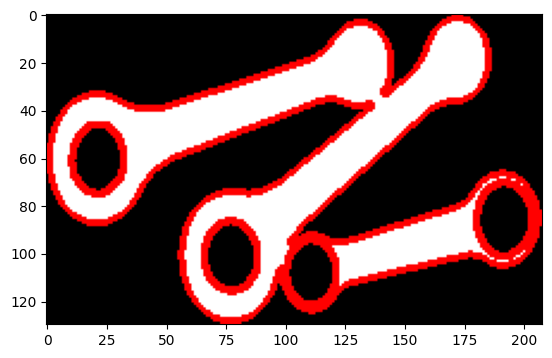

In [104]:
for i in range(len(blobs)):
    plt.subplot(1, len(blobs), i+1)
    img = cv2.cvtColor(blobs[i].copy()*255, cv2.COLOR_GRAY2RGB)
    cv2.drawContours(img, ext_cnts[i], -1, [255, 0, 0], thickness=2)
    cv2.drawContours(img, hole_cnts[i], -1, [255, 0, 0], thickness=2)
    plt.imshow(crop_object(img, label=255), cmap='gray')
    
plt.show()

### Screw detection
A screw is an object with no (holes) inner contours, so by exploiting the hierarchy given by findCountours() we find and remove any object that does not present at least an hole (child contour).

In [105]:
nonscrew_indices = np.where([len(hole_cnt) > 0 for hole_cnt in hole_cnts])[0]
hole_cnts        = np.take(hole_cnts, nonscrew_indices, axis=0)
ext_cnts         = np.take(ext_cnts, nonscrew_indices, axis=0)
blobs            = np.take(blobs, nonscrew_indices, axis=0)

/Users/albertomordonini/opt/anaconda3/envs/aas/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


## Remove washers

To identify a washer we determine how much an object's shape is *circular* and then cut any of them having high circularity factor. \
Let's introduce the Barycentre first, which is needed to compute the Circularity (we'll also need it later).\
The position of the barycentre is the sum of pixel's coordinates beloning to the same component, divided by its area
- ##### $B =\begin{bmatrix} i_b\\j_b \end{bmatrix} = \frac{1}{A} \begin{bmatrix} \sum_{p\in Component}^{}i_p \\ \sum_{p\in Component}^{}j_p \end{bmatrix}$


The above formula can be applied to contours instead of the whole component, thus we treat the number of (contour)points as the area

In [106]:
def compute_centroid(points):
    area = len(points)
    
    sum_coords = points.sum(0)
    return np.round(sum_coords/area).astype(int)

barycentres = np.array([compute_centroid(np.flip(np.argwhere(blobs[i]), axis=1)) for i in range(len(blobs))])

#### Haralick Circularity

Let us define:
- ##### $\mu = \frac{1}{N}\sum_{k=1}^{N}d_k$
- ##### $\sigma^2 = \frac{1}{N}\sum_{k=1}^{N}(d_k - \mu)^2$
- ##### $d_k = \left \| p_k - B \right \|, p_k = \begin{bmatrix} i_k\\ j_k\end{bmatrix}$

$\mu$ is the mean distance between contour points and the barycentre\
$\sigma$ is the standard deviation of such distances\
$N$ is the number of pixels belonging to the contour\
$d_k$ is the distance between the k-th contour point and the barycentre\

Haralick's Circularity is defined as follow:
- ##### $C = \frac{\mu}{\sigma}$

So the feature gets bigger as the standard deviation gets smaller. 

In [107]:
def haralick_circularity(cnt, barycentre):
    n = len(cnt)
    
    distances = np.array([np.linalg.norm(p - barycentre) for p in cnt])
    
    mu = distances.sum()/n
    sigma_square = np.sum((distances - mu) ** 2)/n
    
    return mu/np.sqrt(sigma_square)
    
circularities = np.array([haralick_circularity(cnt, barycentres[i]) for (i, cnt) in enumerate(ext_cnts)]).round(2)

#### Blobs featuring high circularity(i.e. washers) are filtered out

In [108]:
CIRCULARITY_THRESHOLD = 3.0

# indices of blobs featuring low circularity (i.e. rods)
indices = np.where(circularities <= CIRCULARITY_THRESHOLD)[0]
blobs          = np.take(blobs, indices, axis=0)
ext_cnts       = np.take(ext_cnts, indices, axis=0)
hole_cnts      = np.take(hole_cnts, indices, axis=0)
barycentres    = np.take(barycentres, indices, axis=0)

### Printing remaining blobs

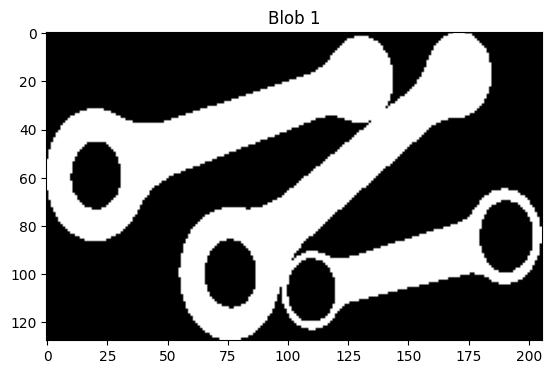

In [109]:
show_many_blobs(blobs)

# Remove Contact Points

Contacts between rods prevents us from analyzing rods, since the labeling process would mark many connecting rods as just one, therefore they must be removed.

Let us define the convex hull of a shape as the smallest convex object that contains it and is entirely described by a set of vertexes.

Then, for any side of the convex hull(described by a couple of vertexes A and B), a possible contact point is found as the one featuring maximum distance between the side of the hull and the n-point belonging to the contour of the object and delimited by A and B.

- ##### $Possible Contact Points = \{ \underset{p} \argmax\ distance(p, L),\ p\in [A, B] \}_{L=line(A, B)\in ConvexHull}$

Pruning weak possible contact points is mandatory, since we'll end up having an occurrence for EACH side of the convex hull. Therefore, thresholding by considering nonzero-pizels within the neighbourhood(5x5) of such points provides to eliminate unwanted points.
- ##### $p_i$, i-th Possible contact point
- ##### Number of foreground px within a k-Neighbourhood: $N_k(p_i)$
- ##### $L$, length of $Possible Contact Points$
- ##### Threshold:$\ T = 0.7 \cdot k^2$, with $k$ being the kernel size

Optimal contact points are defined as follow:
- ##### $ContactPoints$ : $\{p_i \in Possible Contact Points\ |\ N_5(p_i) > T\}$

In [110]:
def find_defect_points(cnt):
    pts = cnt.copy()
    epsilon = 0.01*cv2.arcLength(pts,True)
    pts = cv2.approxPolyDP(pts, epsilon, True)

    # convex hull object
    hull_defects = cv2.convexHull(pts, returnPoints=False)
    defect_vec = cv2.convexityDefects(pts, hull_defects) # returns (start_index, end_index, def_point_index, defpoint_hull_distance)
    def_points = np.take(pts.squeeze(1), defect_vec.squeeze(1)[:, 2], axis=0)

    return def_points

In [111]:
def threshold_fn(tolerance, k=5):
    threshold = k**2 * tolerance
    return threshold
    

def get_neighbour(src, pt, size=5):
    window_size = size//2

    # pad to prevent bounding errors
    template = np.pad(src, window_size)

    # centre coordinates
    x, y = pt + window_size     # shift by the padding factor to refine centre
    neighbourhood = template[y-window_size:y+window_size+1, x-window_size:x+window_size+1].copy()
    
    return neighbourhood

DEF_POINTS_NONZERO_PX_TOLERANCE = .7
def prune_defect_points(src, pts, k=5):
    # Get k x k neighbourhoods of such points
    neighbourhoods = np.asarray([get_neighbour(src, p, k) for p in pts])

    # count nonzero pixels
    nonzero_pixels = neighbourhoods.sum(axis=1).sum(axis=1)

    threshold = threshold_fn(DEF_POINTS_NONZERO_PX_TOLERANCE, k)

    good_points_mask = nonzero_pixels > threshold
    good_ones = pts[good_points_mask]
    bad_ones = pts[~good_points_mask]

    return good_ones, bad_ones

In [112]:
from sklearn.neighbors import KDTree

def find_closest_points(points):
    kdt = KDTree(points, leaf_size=30, metric='euclidean')
    distances, ind = kdt.query(points, k=2)

    result = []
    dist = distances[:, 1].copy()

    # at each iteration, the two closest points
    # are paired and removed from the data structure.
    while dist.min() < float('inf'):
        p1_idx = np.argmin(dist)
        p2_idx = ind[p1_idx, 1]

        p1 = points[p1_idx]
        p2 = points[p2_idx]
        result.append([p1, p2])
        dist[p1_idx] = float('inf')
        dist[p2_idx] = float('inf')

    return np.array(result)

In [113]:
def remove_contact_points(src, cont_points):
    checking = src.copy()
    # draw background lines between each pair of contact points
    [cv2.line(checking, couple[0], couple[1], BACKGROUND, lineType=cv2.LINE_8, thickness=1) for couple in cont_points]
    
    # labeling
    components, labs = label_components(checking.astype(np.int32))
    separated_blobs = [separate_blob(components, l, crop=False) for l in labs]

    return separated_blobs

In [114]:
def show_defect_points(src, good_ones, bad_ones):

    template = src.copy()
    BAD_INTENSITY = [255,0,0]
    GOOD_INTENSITY = [0,0,255]
    
    test_img = np.dstack((template.copy()*255,)*3).astype(np.int32)     # Gray(1 channel) to RGB (3 channels)
    
    [cv2.circle(test_img, c, 3, BAD_INTENSITY, -1) for c in bad_ones]       # red circles enhance unwanted contact points
    [cv2.circle(test_img, c, 3, GOOD_INTENSITY, -1) for c in good_ones]      # blue circles enhance strong contact points
    # printing
    show_blob(test_img, crop=False)

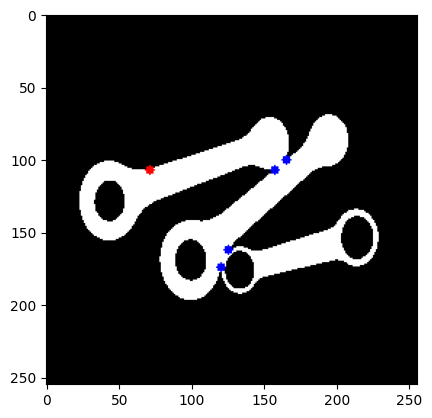

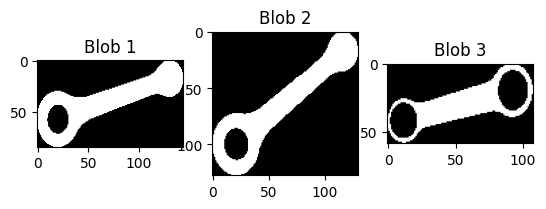

In [115]:
bad_blobs_indices = []
for i, b in enumerate(blobs):

    # Obtain defect points
    defect_points = find_defect_points(ext_cnts[i])

    # Prune weak defect points
    good_def_points, bad_def_points = prune_defect_points(b.astype(np.int32), defect_points) # bad points are also keeped to be printed

    # Blob is analysed if at least one good defect point is found
    condition = good_def_points.shape[0] > 0

    if condition:
        show_defect_points(b, good_def_points, bad_def_points)
        bad_blobs_indices.append(i)
        
        # pair contacts points
        contact_points = find_closest_points(good_def_points)
        
        # Remove contacs
        new_blobs = np.asarray(remove_contact_points(b, contact_points))
        
        # Image reconstruction.
        # If a newly found blob has a very low number of points compared 
        # the others, it means that it's a part of another blob which was cut
        # away during the detach process and is marked as "outlier"
        nonzero_pixels = new_blobs.sum(1).sum(1)
        mask = nonzero_pixels > np.linalg.norm(np.diff(contact_points, axis=0))
        outliers = new_blobs[~mask]
        new_blobs = new_blobs[mask]

        # If any outlier is found, it is drawn (logical OR) into 
        # every other blob, as well as a FOREGROUND line drawn
        # to separate the attached blobs, then a median filter is applied
        # to each of them, to cut off outliers
        if np.any(~mask):   
            # Draw outliers into new blobs
            for o in outliers:  new_blobs = new_blobs | o

            # Draw a FOREGROUND line between contacts on each SEPARATED blob.
            [[cv2.line(sb, cp[0], cp[1], FOREGROUND) for i,cp in enumerate(contact_points)] for sb in new_blobs]
            
        new_blobs = np.array([remove_powder(sb) for sb in new_blobs])

        # Get new contours
        new_ext_cnts, new_hole_cnts = get_contours(new_blobs)

        # New barycentres
        new_barycentres = np.array([compute_centroid(np.flip(np.argwhere(b), axis=1)) for b in new_blobs])

        # Append new features relative to the new(separated) blobs
        blobs = np.vstack((blobs, new_blobs))
        barycentres = np.vstack((barycentres, new_barycentres))

        ext_cnts = ext_cnts.tolist()
        [ext_cnts.append(nb) for nb in new_ext_cnts]
        ext_cnts = np.array(ext_cnts, dtype=object)

        hole_cnts = hole_cnts.tolist()
        [hole_cnts.append(nb) for nb in new_hole_cnts]
        hole_cnts = np.array(hole_cnts, dtype=object)

        
for i in bad_blobs_indices:
    # Delete features relative to the deleting blob
    blobs = np.delete(blobs, i, axis=0)
    barycentres = np.delete(barycentres, i, axis=0)
    ext_cnts = np.delete(ext_cnts, i, axis=0)
    hole_cnts = np.delete(hole_cnts, i, axis=0)
    
show_many_blobs(blobs)

# Orientation

The orientation, i.e. the angle between major-axis and horizontal-axis, has been computed using the covariance matrix and seeking for eigenvector associated with the highest eigenvalue, since it is aligned with the major axis.

In [116]:
def compute_orientation(points):
    coords = points.copy()

    # Obtain covariance matrix
    cov = np.cov(coords.T)  
    
    # Look for the eigenvectors and eigenvalues
    evals, evecs = np.linalg.eig(cov)
    sort_indices = np.argsort(evals)[::-1]
    e1_i, e1_j = evecs[:, sort_indices[0]]  # Eigenvector associated with the largest eigenvalue

    # argument of the eigenvector
    theta = -np.arctan((e1_i)/(e1_j))        # angle
    return theta

orientations_rad = np.expand_dims([compute_orientation(np.flip(pts.squeeze(1), axis=1)) for i, pts in enumerate(ext_cnts)], -1)
orientations_rad = np.where(orientations_rad > 0, orientations_rad, np.pi + orientations_rad) # let the orientation be modulo pi

# along major axis
orientations = orientations_rad*180/np.pi

# along minor axis (add 90 degrees)
orientations_min_rad = orientations_rad + np.pi/2
orientations_min = orientations_min_rad * 180/np.pi

# Length and Width

To find out the size of the MER(minimum oriented rectangle) we take the contour points of each blob and rotate it, according to the orientation found above, to let contours assume a *vertical* position

In [117]:
def rotate(points, angle, centre):
    pts = points.copy()

    # build rotation matrix
    s, c = np.sin(angle), np.cos(angle)
    rot_matrix = np.array([[c, -s], [s, c]])

    # rotate points
    new_coords = (pts - centre) @ rot_matrix + centre
    new_coords = new_coords.round().astype(np.int32)

    # Due to the rounding operation, the figure described by the new set of points
    # may be "opened" in some areas, therefore we exploit the drawContours function
    # to "close" those regions.
    before_fill = new_coords.shape[0]
    template = np.zeros((new_coords[:, 1].max()+1, new_coords[:, 0].max()+1))           # black box
    img = cv2.drawContours(template.copy(), [new_coords], -1, 1, lineType=cv2.LINE_8)

    # cropping
    new_coords = np.flip(np.argwhere(img), axis=1)
    after_fill = new_coords.shape[0]
    filled_points = after_fill - before_fill
    print(f"Filled with {filled_points} point{'s' if filled_points > 1 else ''}")

    return new_coords
    
rotation_angles = np.pi / 2 - orientations_rad  # angle between major axis and vertical axis
rotation_angles = np.squeeze(rotation_angles, axis=1)
rotated_ext_cnts = [rotate(pts.squeeze(1), rotation_angles[i], barycentres[i]) for i,pts in enumerate(ext_cnts)]

Filled with 32 points
Filled with 70 points
Filled with 18 points


### Show rotated contours

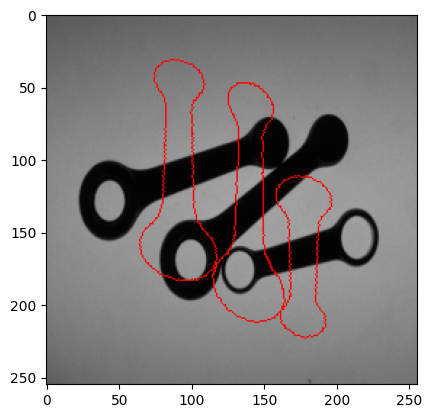

In [118]:
rotated_contours_img = src.copy()
for i, cnt in enumerate(rotated_ext_cnts):
    
    # black boxes
    cnt = np.expand_dims(cnt,1)
    cv2.drawContours(rotated_contours_img, cnt, -1, [255, 0, 0], lineType=cv2.LINE_8)
    
    # cropping
    
plt.imshow(rotated_contours_img)
plt.show()


Then, the length($L$) is computed as the difference between the maximum and minimum value along vertical-axis, As well as is for the width($W$) along horizontal axis.

$L = \max{i} - \min{i}$ \
$W = \max{j} - \min{j}$

In [119]:
measures = np.array([[cnt[:, 1].max() - cnt[:, 1].min(), cnt[:, 0].max() - cnt[:, 0].min()] for cnt in rotated_ext_cnts]).astype('int32')
lengths = measures[:, 0]
widths = measures[:, 1]

# <span id="Classification">Classification</span>

Rods are classified by their number of holes, which can be found by counting the number of internal contours of each blob.

In [120]:
rod_classes = ['A', 'B'] # A: one hole, B: two holes

classes = np.array([rod_classes[len(int_cnt)-1] for int_cnt in hole_cnts])

# Centre Position and Radius of Holes

Radius has been computed as the mean distance between (inner)contour points and their centre(e.g. barycentre)
#### $r = \frac{1}{N}\sum_{k=1}^{N}\left \| p_k - B \right \|$

In [121]:
def radius(points):
    bary = compute_centroid(points)
    distances = np.linalg.norm(points - bary, axis=1)
    
    radius = distances.mean().round().astype(np.int32)

    # hole barycentres will be used to draw the diameter later
    return radius, bary.round().astype(int)

data = np.array([[radius(pts.squeeze(1)) for pts in holes] for holes in hole_cnts], dtype=object)
radiuses = [[x[0] for x in blob] for blob in data]
hole_centres = np.array([[x[1] for x in blob] for blob in data])

/Users/albertomordonini/opt/anaconda3/envs/aas/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


# Width at Barycentre


We exploit the rotated contours computed few steps ago. In facts, the $W_B$ can be obtained by just measuring the distance between the points in the same *row* of the barycentre of the vertically-aligned contour.

In [122]:
def barycentre_width(points):
    pts = points.copy()

    # centroid has to be computed for the rotated blob
    bary = compute_centroid(pts)
    _, y_bary = bary

    # second column of the points that
    # represents vertical components
    q = pts[:, 1]

    # indices of points laying in the same
    # horizontal line of the barycentre
    indices = np.nonzero(q == y_bary)[0]
    coords = np.take(pts, indices, axis=0)   # points coordinates

    # depending on the connectivity (4 or 8),
    # more than 2 points may be found, so we take the 
    # WB as the mean doubled-distance between points
    # found above and the barycentre
    distances = np.linalg.norm(coords - bary, axis=1)
    wb = (distances*2).mean().round().astype(int)
    
    return wb

wbs = [barycentre_width(rotated_ext_cnts[i]) for i in range(len(blobs))]

# Drawing
In this section, images are prepared to be printed out: the minimum oriented rectangle(MER) and the diameter of each inner-hole will be drawn within the blob to improve readability, other features will be simply written in. 

In [123]:
def compute_axes(angle, bary):
    alpha = np.sin(angle)
    beta = np.cos(angle)
    j, i = bary

    major_axis = (alpha, -beta, beta*i - alpha*j)
    minor_axis = (beta, alpha, -beta*j - alpha*i)
    return major_axis, minor_axis

axes = np.array([np.vstack(compute_axes(orientations_rad[i][0], barycentres[i])) for i in range(len(blobs))])

In [124]:
def box_points(points, major_axis, minor_axis):

    def signed_distance(point, line):
        a,b,c = line
        i, j = point
        
        d = (a*j +b*i + c)/np.sqrt(a**2 + b**2)
        return d

    def max_distance_points(points, major, minor):
        pts = points.copy()
        dMAmin = float('inf')
        dMAmax = float('-inf')
        dMImin = float('inf')
        dMImax = float('-inf')

        for i, p in enumerate(pts):
            dMA = signed_distance(p, major)
            dMI = signed_distance(p, minor)

            if dMA < dMAmin:    dMAmin = dMA;   c1 = p.copy()   # point having minimum (signed) from major-axis
            if dMA > dMAmax:    dMAmax = dMA;   c2 = p.copy()   # point having maximum (signed) from major-axis
            if dMI < dMImin:    dMImin = dMI;   c3 = p.copy()   # point having minimum (signed) from minor-axis
            if dMI > dMImax:    dMImax = dMI;   c4 = p.copy()   # point having maximum (signed) from minor-axis

        return np.vstack((c1, c2, c3, c4))

    max_dist_pts = max_distance_points(points, major_axis, minor_axis)
    # define axes parameters
    a, b, _ = major_axis
    a2, b2, _ = minor_axis
    b = -b
    b2 = -b2

    p1, p2, p3, p4 = max_dist_pts
    # define points components
    j1, i1 = p1;    j2, i2 = p2;    j3, i3 = p3;    j4, i4 = p4

    # define 3rd parameter of each of the two lines parallel to the
    # major and minor axis. Starting from axis equation, they differ
    # by the constant value (c) only and it is calculated according 
    # to the coordinates of the points computed above (p1, p2, p3, p4)
    cw1 = -(a2*j1 + b2*i1)      # line w1: parallel to minor axis through p1
    cw2 = -(a2*j2 + b2*i2)      # line w2: parallel to minor axis through p2
    cl1 = -(a*j3 + b*i3)        # line l1: parallel to major axis through p3
    cl2 = -(a*j4 + b*i4)        # line l2: parallel to major axis through p4

    # intersections yield the vertexes of the oriented MER
    i_v1 = (a2*cl1 - a*cw1);    j_v1 = (b*cw1 - b2*cl1)     # w1 V l1 
    i_v2 = (a2*cl1 - a*cw2);    j_v2 = (b*cw2 - b2*cl1)     # w2 V l1
    i_v3 = (a2*cl2 - a*cw1);    j_v3 = (b*cw1 - b2*cl2)     # w1 V l2 
    i_v4 = (a2*cl2 - a*cw2);    j_v4 = (b*cw2 - b2*cl2)     # w2 V l2

    vertexes = np.vstack([
        [j_v2, i_v2],
        [j_v1, i_v1],
        [j_v3, i_v3],
        [j_v4, i_v4]]) / (a*b2 - b*a2)

    vertexes = vertexes.round().astype(np.int32)

    return max_dist_pts, vertexes

data = [box_points(ext_cnts[i].squeeze(1), axes[i][0], axes[i][1]) for i in range(len(blobs))]
max_dist_points = np.array([d[0] for d in data])
box_vertexes = np.array([d[1] for d in data])

### Minimum Oriented Rectangle
Minimum oriented rectangle is drawn according to the vertexes found above.
Every blob is wrapped inside a bigger empty image to improve the visibility of the MER itself. \
Barycentres (red dots) and points having max/min signed distance between axes (blue dots) are also drawn in this section.

In [125]:
def draw_rect(src, vertexes, centre, angle, mer_index=1):
    box = src                

    # draw MER vertexes
    cv2.drawContours(box, [vertexes], -1, [255, 0, 0], thickness=1) 

    # direction arrows
    distance = 30
    p1 = centre + distance*np.array([np.cos(angle), -np.sin(angle)])                      # arrow along major axis
    p2 = centre + distance/2*np.array([np.cos(angle+np.pi/2), -np.sin(angle+np.pi/2)])    # arrow along minor axis
    p1 = p1.round().astype(np.int32)
    p2 = p2.round().astype(np.int32)
    cv2.arrowedLine(box, centre, p1, [0,255,0], tipLength=.25)
    cv2.arrowedLine(box, centre, p2, [0,255,0], tipLength=.25)
    cv2.putText(src, f"{mer_index}", vertexes[1] + [0, -5], cv2.FONT_HERSHEY_SIMPLEX, 0.80,  [255, 0, 0])

    # centroid
    cv2.circle(box, centre, 1, [255, 0, 0], thickness=2)
    
    return box

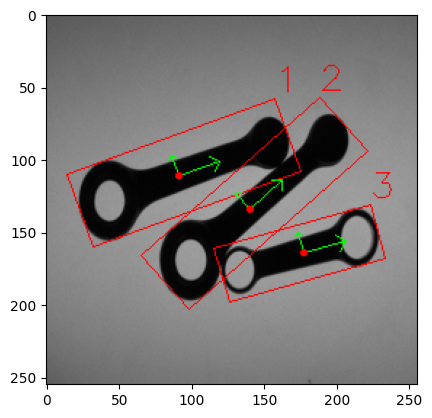

In [126]:
outcome = src.copy()
[draw_rect(outcome, box_vertexes[i], barycentres[i], angle[0], mer_index=i+1) for i,angle in enumerate(orientations_rad)];
plt.imshow(outcome)
plt.show()

Utility function: given a source image and a set of points, representing the contour of a hole, draws a red diameter arrowed line along the diameter and a text that underlines its length

In [127]:
def draw_diameter(src, points, draw_text=True, padding=0, hole_index=1):
    rad, centre = radius(points)
    cx, _ = centre
    
    min_x = points[:, 0].min()
    max_x = points[:, 0].max()
    
    p1 = centre - [cx - min_x - 1, 0] + padding     # starting point
    p2 = centre + [max_x - cx - 1, 0] + padding     # ending point

    text_point = centre + [-4, 10] + padding
    index_text_point = centre + [-2, -6] + padding
    cv2.arrowedLine(src, p1, p2, [0, 0, 255], tipLength=0.15)    # tipLength = arrow length
    cv2.arrowedLine(src, p2, p1, [0, 0, 255], tipLength=0.15)
    cv2.circle(src, centre, 2, [0, 255, 255], thickness=-1)
    if draw_text: 
        cv2.putText(src, f"{2*rad}",text_point, cv2.FONT_HERSHEY_SIMPLEX, 0.20,  [0, 0, 255])
        cv2.putText(src, f"{hole_index}",index_text_point, cv2.FONT_HERSHEY_SIMPLEX, 0.20,  [0, 0, 255])
    return src

Drawing every diamater

In [128]:
[[draw_diameter(outcome, holes.squeeze(1), hole_index=i+1) for i, holes in enumerate(pts)] for pts in hole_cnts];

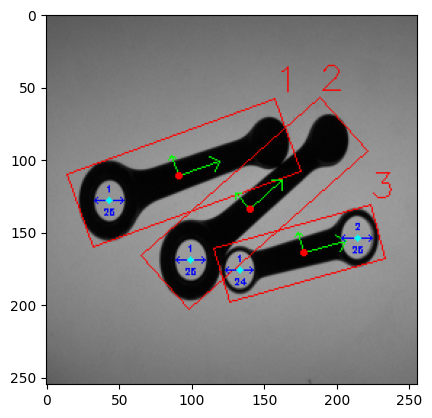

------------------------- 1 -------------------------
Class: A, Angle: 0.349 rad, Centre: [ 91 111]
Length: 152, Width: 53, Width at barycentre: 20
Hole 1: Centre = [ 43 128], Diameter = 26
------------------------- 2 -------------------------
Class: A, Angle: 0.726 rad, Centre: [140 134]
Length: 165, Width: 50, Width at barycentre: 19
Hole 1: Centre = [ 99 169], Diameter = 26
------------------------- 3 -------------------------
Class: B, Angle: 0.278 rad, Centre: [177 164]
Length: 112, Width: 38, Width at barycentre: 19
Hole 1: Centre = [133 176], Diameter = 24
Hole 2: Centre = [214 154], Diameter = 26


In [129]:
plt.imshow(outcome)
plt.show()
outstruct = dict()
for i, b in enumerate(blobs):
    # datastruct
    tmp = dict()
    tmp['class']  = classes[i]
    tmp['angle']  = orientations_rad[i][0].round(3)
    tmp['centre'] = barycentres[i].tolist()
    tmp['length'] = int(lengths[i])
    tmp['width']  = int(widths[i])
    tmp['widthB'] = int(wbs[i])
    tmp['holes']  = [{'centre':hole_centres[i][x].tolist(), 'diameter':int(r*2)} for x,r in enumerate(radiuses[i])]
    outstruct[i+1] = tmp

    # printing
    print("-"*25,i+1,"-"*25)
    print(f"Class: {classes[i]}, Angle: {orientations_rad[i][0].round(3)} rad, Centre: {barycentres[i]}")
    print(f"Length: {lengths[i]}, Width: {widths[i]}, Width at barycentre: {wbs[i]}")
    [print(f"Hole {x+1}: Centre = {hole_centres[i][x]}, Diameter = {r*2}") for x,r in enumerate(radiuses[i])]
    

In [130]:
import json
# save output json
with open(OUT_DIR+src_name+'_OUT.json', "w") as outjs:
    json.dump(outstruct, outjs, indent=4)

# save output image
cv2.imwrite(OUT_DIR+src_name+'_OUT.BMP', np.flip(outcome, axis=2));